pixelliste für einen nutzer holen

In [1]:
from src.data.dataset_functions import get_dataframe

dataFrame = get_dataframe(True) # sample data only
from src.features.feature_functions import group_dataframe_by_user
groupedFrame = group_dataframe_by_user(dataFrame)


providing ../data/raw/2022_place_canvas_history-000000000050.csv ...
../data/raw/2022_place_canvas_history-000000000050.csv is already in data/raw


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/13 01:25:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
headrow = groupedFrame.head(1)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from src.models.models import RZModel

headrow = headrow[0]
print(headrow)


Row(user_id='AxBTmhBMbr1sbDw/2liFySQ4h6lH1bZSyjS9RtcBxvMyafVj+e2grv9teqbU9JkFDCPlgIfWH+L2CzKeSBdB4w==', count=20, collect_list(x)=[1447, 1617, 655, 612, 1575, 1287, 1636, 1926, 658, 1310, 1403, 1299, 777, 586, 1741, 584, 1611, 1765, 788, 656], collect_list(y)=[5, 16, 1896, 1917, 7, 8, 21, 19, 14, 10, 2, 20, 8, 1931, 10, 26, 33, 8, 11, 1884], collect_list(t)=[184, 1417, 1726, 1726, 1726, 801, 492, 801, 2035, 1109, 2344, 2653, 2344, 2653, 2344, 3577, 3269, 3577, 2961, 2961], collect_list(pixel_color)=['#FFA800', '#FF4500', '#B44AC0', '#E4ABFF', '#FFA800', '#3690EA', '#FFFFFF', '#BE0039', '#FF4500', '#2450A4', '#FFA800', '#FFFFFF', '#FFA800', '#9C6926', '#FFA800', '#000000', '#2450A4', '#FFA800', '#000000', '#E4ABFF'])


[[1447, 1617, 655, 612, 1575, 1287, 1636, 1926, 658, 1310, 1403, 1299, 777, 586, 1741, 584, 1611, 1765, 788, 656], [5, 16, 1896, 1917, 7, 8, 21, 19, 14, 10, 2, 20, 8, 1931, 10, 26, 33, 8, 11, 1884], [184, 1417, 1726, 1726, 1726, 801, 492, 801, 2035, 1109, 2344, 2653, 2344, 2653, 2344, 3577, 3269, 3577, 2961, 2961]]


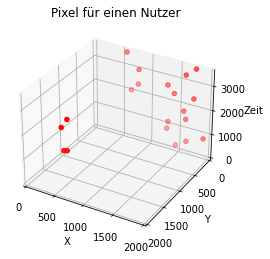

In [7]:
from src.visualization.visuialization_functions import plot_pixel_boundingbox,plot_pixellist,new_xyt_plot
pixelliste = [headrow['collect_list(x)'],headrow['collect_list(y)'],headrow['collect_list(t)']]
print(pixelliste)
subplot = new_xyt_plot()
subplot = plot_pixellist(pixellist=pixelliste,subplot = subplot, finish = False,color='red')
plt.savefig('pixels.png', dpi = 300)
subplot.set_title('Pixel für einen Nutzer')
subplot.set_zlim([0,3601])
plt.savefig('pixels.png', dpi = 300)
plt.show()



[[1447, 1617, 655, 612, 1575, 1287, 1636, 1926, 658, 1310, 1403, 1299, 777, 586, 1741, 584, 1611, 1765, 788, 656], [5, 16, 1896, 1917, 7, 8, 21, 19, 14, 10, 2, 20, 8, 1931, 10, 26, 33, 8, 11, 1884], [184, 1417, 1726, 1726, 1726, 801, 492, 801, 2035, 1109, 2344, 2653, 2344, 2653, 2344, 3577, 3269, 3577, 2961, 2961]]


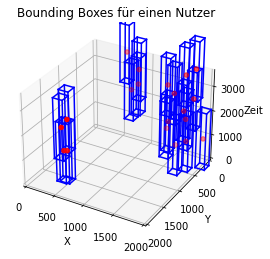

In [9]:
from src.visualization.visuialization_functions import *
import numpy as np
print(pixelliste)
RZModel.max_xy_dist = 80
RZModel.max_t_dist = 20*60
x_list = pixelliste[0]
y_list = pixelliste[1]
t_list = pixelliste[2]
subplot = new_xyt_plot()
subplot = plot_pixellist(pixelliste,subplot = subplot, finish = False,color='red')
for i in np.arange(0,len(x_list)):
    subplot = plot_pixel_boundingbox(x_list[i],y_list[i],t_list[i],color='blue',subplot=subplot,finish=False)

subplot.set_title('Bounding Boxes für einen Nutzer')
subplot.set_zlim([0,3601])
plt.savefig('boxes.png',dpi=300)
plt.show()